In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# visulization: plot figures
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# figure format; comment out them if errors appear
fsize = 15
tsize = 15
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))

Plot NS samples

In [8]:
num_dataset = 5
list_suffix = [f"0{i}" for i in np.arange(1,num_dataset+1)]
list_data_loc = [f"/scratch/yc3400/forecasting/NSEdata/data_file" + i + ".pt" for i in list_suffix]
hi_size = 128
z1 = torch.load(list_data_loc[0])[0]
z1 = torch.nn.functional.interpolate(z1, size=(hi_size,hi_size),mode='bilinear')
z1 = z1.reshape(-1,hi_size,hi_size)
avg_pixel_norm = 3.0679163932800293
z1 = z1/avg_pixel_norm


/state/partition1/job-63252787/ipykernel_128711/1211516489.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z1 = torch.load(list_data_loc[0])[0]


In [9]:
thisdata = z1[:100,None,...]

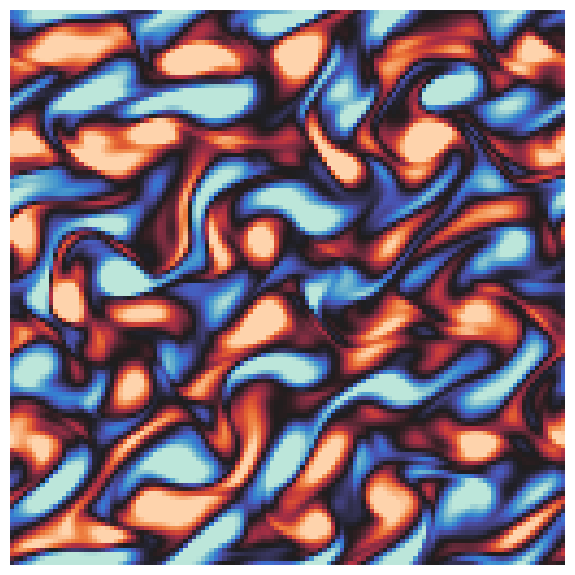

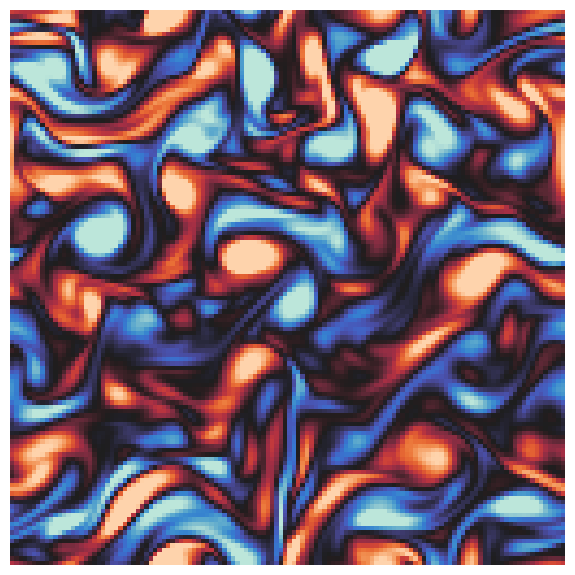

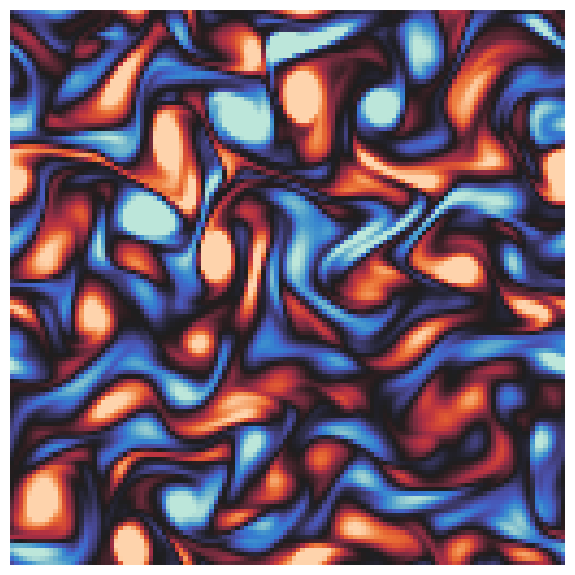

In [13]:
fig = plt.figure(figsize=(6,6))
plt.imshow(thisdata[0,0,...], cmap=sns.cm.icefire, vmin=-2, vmax=2.)
plt.axis("off")
plt.xticks([])  # removes x-axis numbers
plt.yticks([])  # removes y-axis numbers
fig.tight_layout()
fig.savefig('NSsample1.pdf')

fig = plt.figure(figsize=(6,6))
plt.imshow(thisdata[4,0,...], cmap=sns.cm.icefire, vmin=-2, vmax=2.)
plt.axis("off")
plt.xticks([])  # removes x-axis numbers
plt.yticks([])  # removes y-axis numbers
fig.tight_layout()
fig.savefig('NSsample2.pdf')

fig = plt.figure(figsize=(6,6))
plt.imshow(thisdata[8,0,...], cmap=sns.cm.icefire, vmin=-2, vmax=2.)
plt.axis("off")
plt.xticks([])  # removes x-axis numbers
plt.yticks([])  # removes y-axis numbers
fig.tight_layout()
fig.savefig('NSsample3.pdf')

Plot spectrum noise

In [42]:
spectrum_amplitude = torch.load("./enstrohpy_spectrum_amplitude.pt")[None,...]/5 # 1*1*128*128
npix = spectrum_amplitude.shape[-1]
kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)

# spectrum_amplitude = spectrum_amplitude
# spectrum_amplitude = spectrum_amplitude  * torch.tensor(((np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)))).float() /10
spectrum_amplitude = torch.ones_like(spectrum_amplitude)/100
noise_real = torch.randn_like(spectrum_amplitude)
noise_img = torch.randn_like(spectrum_amplitude)

noise = noise_real + 1j * noise_img
tmp = torch.fft.ifftn((spectrum_amplitude)*noise, dim = (2,3),norm = "forward").real

/state/partition1/job-63252787/ipykernel_128711/3612779136.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrum_amplitude = torch.load("./enstrohpy_spectrum_amplitud

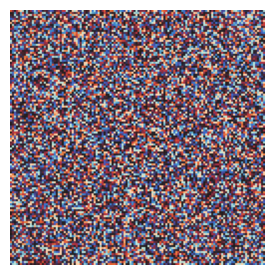

In [45]:
fig = plt.figure(figsize=(3,3))
plt.imshow(tmp[0,0,...], cmap=sns.cm.icefire, vmin=-2, vmax=2.)
plt.axis("off")
fig.tight_layout()
fig.savefig('white_noise.pdf')

Plot spectrum!

In [47]:
import scipy.stats as stats
def get_Fourier_spectrum(data):
    data_hat = torch.fft.fftn(data,dim=(1,2),norm = "forward")
    fourier_amplitudes = np.abs(data_hat)**2
    fourier_amplitudes = fourier_amplitudes.mean(dim=0)
    npix = data_hat.shape[-1]
    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()
    
    kbins = np.arange(0.5, npix//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins_w, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
    Abins_w *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    
    return kvals, Abins_w

In [55]:
kvals, Abins_NS = get_Fourier_spectrum(thisdata[:,0,...])

/state/partition1/job-63252787/ipykernel_128711/4276667180.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  fourier_amplitudes = np.abs(data_hat)**2


In [77]:
import math
def generate_matern_laplace(num_samples, grid_size, sigma_sq=1.0, length_scale=1.0, s=2.0, seed=None):
    """
    Generate Matérn GP using the operator form σ²(-Δ + l²I)^{-s}
    
    Args:
        grid_size (int): Size of the grid (N x N)
        sigma_sq (float): Variance parameter σ²
        length_scale (float): Length scale l
        s (float): Smoothness parameter s
        seed (int): Random seed for reproducibility
    
    Returns:
        torch.Tensor: Sample from the GP
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    # Generate frequency grid (scaled by 2π)
    freq = torch.fft.fftfreq(grid_size) * 2 * math.pi * grid_size
    freq_x, freq_y = torch.meshgrid(freq, freq, indexing='ij')
    
    # Compute -Laplacian in Fourier space: |k|²
    laplacian = freq_x**2 + freq_y**2
    
    # Compute spectral density: σ²(|k|² + l²)^{-s}
    spectral_density = sigma_sq * (laplacian + length_scale**2)**(-s)
    spectral_density[0,0] = 0
    spectral_density = spectral_density.unsqueeze(0)  # adding 1 dim
    
    # Generate complex Gaussian noise
    noise_real = torch.randn(num_samples, grid_size, grid_size)
    noise_imag = torch.randn(num_samples, grid_size, grid_size)
    noise = noise_real + 1j * noise_imag
    
    # Apply sqrt of spectral density
    spectral_sample = torch.sqrt(spectral_density) * noise
    
    # Transform back to spatial domain
    sample = torch.fft.ifft2(spectral_sample, norm='forward')
    sample = sample.real
    
    return sample

GM_sample = generate_matern_laplace(
    num_samples=1000,
    grid_size=128,
    sigma_sq=100,
    length_scale=1.0,
    s=2,
    seed=42
)

In [78]:
kvals, Abins_GM = get_Fourier_spectrum(GM_sample)

/state/partition1/job-63252787/ipykernel_128711/4276667180.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  fourier_amplitudes = np.abs(data_hat)**2


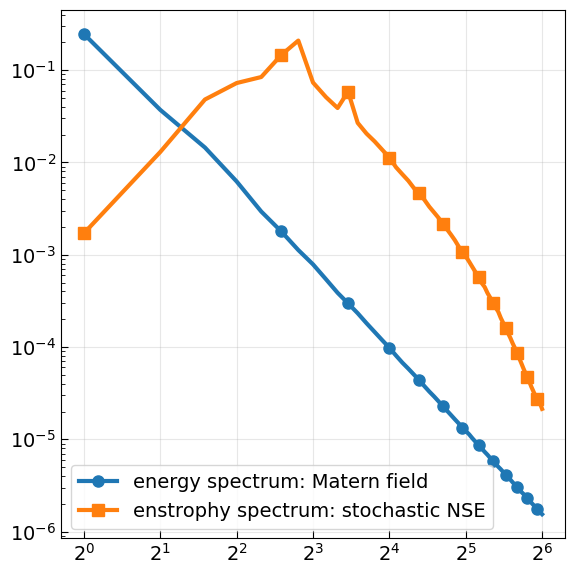

In [81]:
markers = ['o', 's', '^', 'd', 'v']
fig = plt.figure(figsize=(6,6))
plt.plot(kvals, Abins_GM, marker=markers[0], markersize=8, markevery=5, linestyle='-', label = 'energy spectrum: Matern field')
plt.plot(kvals, Abins_NS, marker=markers[1], markersize=8, markevery=5, linestyle='-', label = 'enstrophy spectrum: stochastic NSE')
plt.legend(loc='lower left')
plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.xscale('log', base = 2)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)  # Change 14 to your desired size

plt.tight_layout()
fig.savefig('GM-NSE-spectrum.pdf')